# 04b Multiple Linear regression model trained on good IMD regions 

> k-fold cross validation of regression model choice   

In [46]:
#|default_exp core.04_regression_model

In [47]:
#|hide
import nbdev; nbdev.nbdev_export()

/Users/bea/miniconda3/envs/adu_env_dementia_ineq/lib/python3.10/site-packages/nbdev/export.py:73: UserWarning: Notebook '/Users/bea/adu_dev/dementia_inequalities/nbs/core/03a_explore_datasets.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"


In [48]:
#|hide
from nbdev.showdoc import show_doc

In [49]:
#|export
import dementia_inequalities as proj
from dementia_inequalities import const, log, utils, tools
import adu_proj.utils as adutils

In [50]:
#|export
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score
import itertools

import scipy.stats as st

### Load the Autonomy style bits 

In [51]:
# Define the font path and style path
FONT_PATH = const.raw_data_path + '/JosefinSans-Regular.ttf'
STYLEPATH = const.raw_data_path + '/autonomy_white.mplstyle'

# Add the font to the font manager
fm.fontManager.addfont(FONT_PATH)

# Set the font family for matplotlib to use
plt.rcParams['font.family'] = 'Josefin Sans'
plt.style.use(STYLEPATH)

# Inform the user that the font was set
print("Josefin Sans font set for Matplotlib.")
print("mplstyle activated.")

Josefin Sans font set for Matplotlib.
mplstyle activated.


---

This model looks at automating the choice of parameters and the choice of training dataset using k-fold cross validation. 

In [52]:
#|export 
df_dem_plus = pd.read_csv(const.output_path+'/df_dem_plus.csv')

In [53]:
df_dem_plus.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,white_pc,DEM_afflicted_pc,ALevel_plus_pc,over_65_pc,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,93.2,1.226918,48.025165,34.275376,60.412434,19.073111,6.164929,2.948652,186.084815,0.122844
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,63.0,0.648147,72.016965,20.177787,64.559886,10.372597,3.650571,1.287952,437.450820,0.278995
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,84.2,0.922160,55.139862,23.752404,62.659322,13.584680,4.848008,1.987987,124.734713,0.131269
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,87.8,0.996946,53.341341,23.914299,58.934576,13.640026,5.506448,2.148768,442.084950,0.358794
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,93.8,0.805733,48.818156,29.486050,62.572808,15.965501,6.298085,2.250735,78.032656,0.114776


These are the covariates I'm interested in - each is calculated as a percentage of the total population of the region. 
* Age (% people over 65) `over_65_pc`
* Gender (% people female) `female_pc`
* Educational attainment (% people with A-level or higher education) `ALevel_plus_pc`
* Ethnicity (% people who are white British) `white_pc`
* Comorbidities (% people with various dementia comorbidities)
    - Hypertension `HYP_afflicted_pc`
    - Diabetes `DM_afflicted_pc`
    - Stroke `STIA_afflicted_pc`
* Density of GPs (total number of GPs/ pop) `GP_LAD_pc`

In [54]:
# Potential covariates 
covar_opt = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
             'HYP_afflicted_pc', 
             'DM_afflicted_pc', 
             'STIA_afflicted_pc', 
             'GP_LAD_pc']

covar_opt_noGP = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
             'HYP_afflicted_pc', 
             'DM_afflicted_pc', 
             'STIA_afflicted_pc']

How do we understand these residuals? Might be a good idea to look at the areas which we would expect to have high rates of diagnosis - for example if we look at top 50 areas accoridng to the IMD (or ADI). 

In [55]:
df_IMD = pd.read_excel(const.data_path+'/IoD2019_Local_Authority_District_Summaries__lower-tier__.xlsx', sheet_name='IMD')

In [56]:
# the 50 least deprived LADs according to the IMD
least_50_IMD = list(df_IMD[df_IMD['IMD - Rank of average rank ']>317-60]['Local Authority District name (2019)'])

# check the overlap between regions in IMD and ADI 
df_dem_topIMD = df_dem_plus[df_dem_plus['area_name'].isin(least_50_IMD)].copy()

list_45 = list(df_dem_topIMD['area_name'])
list(set(least_50_IMD).difference(list_45))

['Chiltern',
 'South Bucks',
 'Wycombe',
 'Aylesbury Vale',
 'South Northamptonshire']

In [57]:
print(least_50_IMD)

['York', 'Rutland', 'Bath and North East Somerset', 'South Gloucestershire', 'Bracknell Forest', 'West Berkshire', 'Windsor and Maidenhead', 'Wokingham', 'Central Bedfordshire', 'Aylesbury Vale', 'Chiltern', 'South Bucks', 'Wycombe', 'East Cambridgeshire', 'South Cambridgeshire', 'Derbyshire Dales', 'Brentwood', 'Chelmsford', 'Rochford', 'Uttlesford', 'Cotswold', 'Stroud', 'Tewkesbury', 'East Hampshire', 'Eastleigh', 'Fareham', 'Hart', 'Test Valley', 'Winchester', 'North Hertfordshire', 'Three Rivers', 'Tunbridge Wells', 'Ribble Valley', 'Blaby', 'Harborough', 'North Kesteven', 'South Northamptonshire', 'Harrogate', 'Rushcliffe', 'South Oxfordshire', 'Vale of White Horse', 'West Oxfordshire', 'Elmbridge', 'Epsom and Ewell', 'Guildford', 'Mole Valley', 'Reigate and Banstead', 'Surrey Heath', 'Tandridge', 'Waverley', 'Woking', 'Stratford-on-Avon', 'Warwick', 'Horsham', 'Mid Sussex', 'Bromsgrove', 'St Albans', 'East Hertfordshire', 'Kingston upon Thames', 'Richmond upon Thames']


2020, the former District Council areas of Aylesbury Vale, Chiltern, South Bucks and Wycombe and Buckinghamshire County Council came together to form a single Unitary Authority, Buckinghamshire Council.

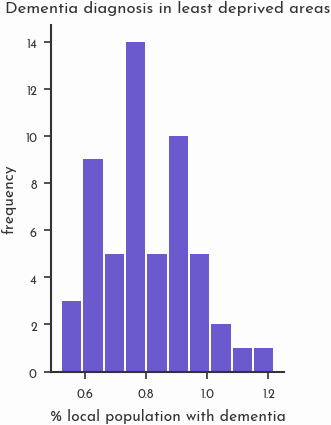

In [58]:
# dementia diagnosis in least deprived areas 
dem_diag_least_IMD = df_dem_topIMD['DEM_afflicted_pc']

# histogram plot of frequency of diagnosis % 
plt.hist(dem_diag_least_IMD, color='slateblue', rwidth=0.9)
plt.title('Dementia diagnosis in least deprived areas')
plt.xlabel('% local population with dementia')
plt.ylabel('frequency')
plt.show()

## All possible covariates 
What happens if I include all possible covariates?

In [59]:
print(covar_opt)

['over_65_pc', 'female_pc', 'ALevel_plus_pc', 'white_pc', 'HYP_afflicted_pc', 'DM_afflicted_pc', 'STIA_afflicted_pc', 'GP_LAD_pc']


In [60]:
# Linear regression using sklearn 

x_IMD_train = df_dem_topIMD[covar_opt].values.reshape(-1,len(covar_opt))
y_IMD_train = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all = df_dem_plus[covar_opt].values.reshape(-1,len(covar_opt))
y_test_all = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_IMD_train, y_IMD_train)
y_pred_all = regr.predict(x_test_all)

In [61]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.2601046485665065
-------- 
 coefficients of independent variables 
 
over_65_pc:0.016628920129419193 

female_pc:0.006522776295720017 

ALevel_plus_pc:-0.006062101759672224 

white_pc:-0.004551849264804488 

HYP_afflicted_pc:0.009396572480384993 

DM_afflicted_pc:-0.023573466000790595 

STIA_afflicted_pc:0.23335918385279206 

GP_LAD_pc:-0.023135544872407904 



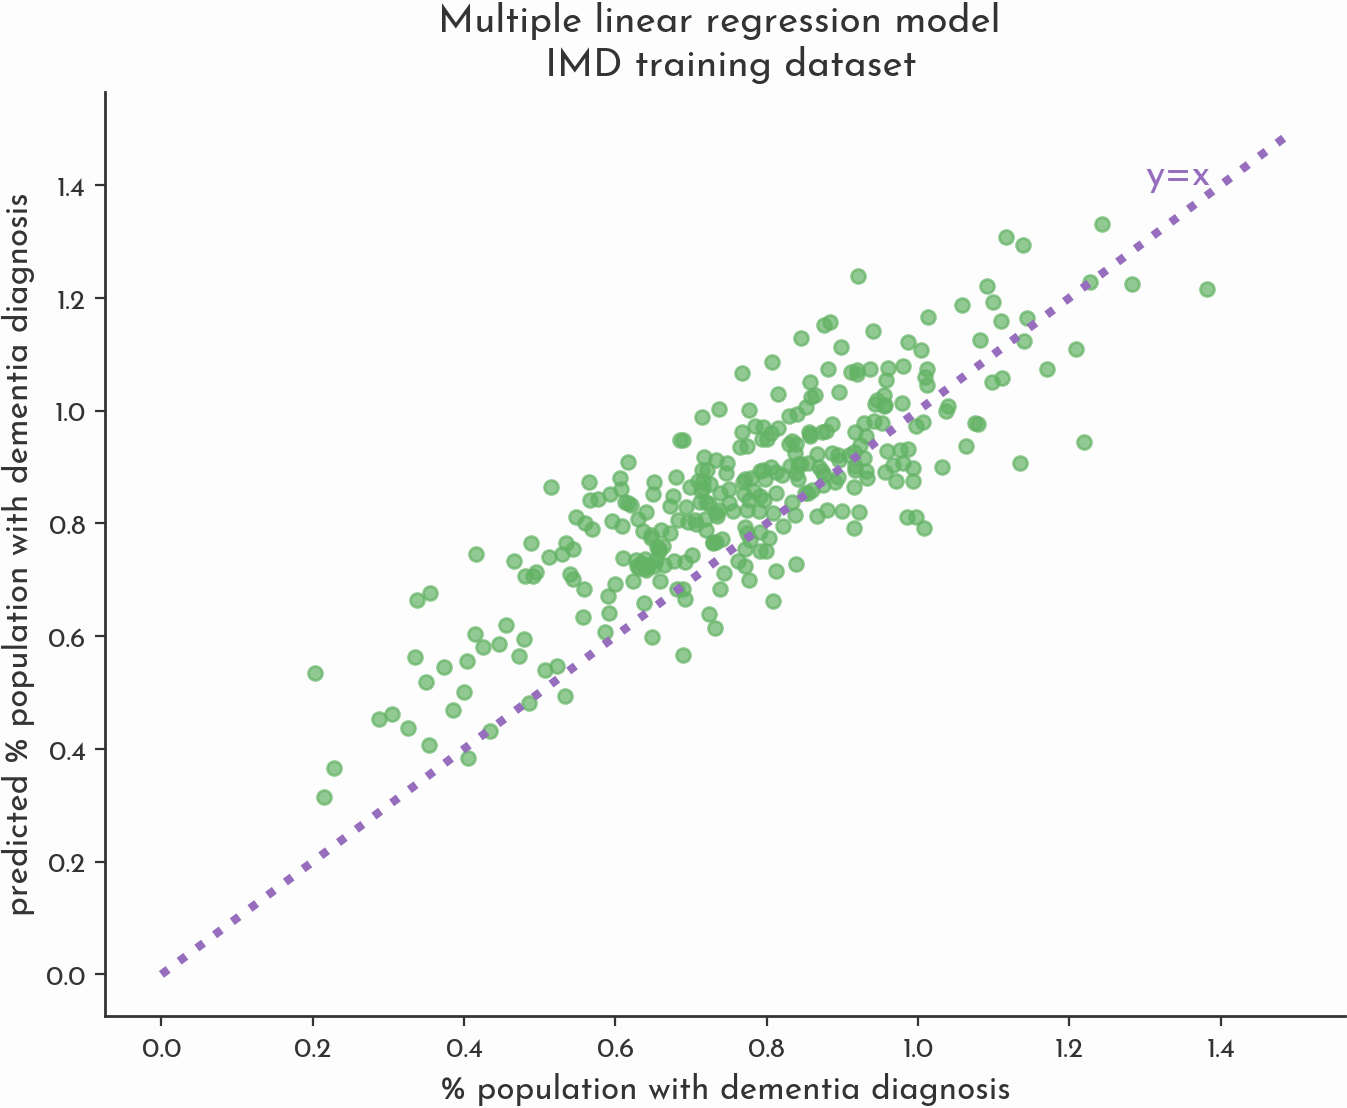

In [62]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.figure(figsize=(8,6), dpi=200)
plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='xkcd:deep lilac')
plt.scatter(y_test_all, y_pred_all, color='xkcd:boring green', alpha=0.7)
plt.xlabel('% population with dementia diagnosis', fontsize=12)
plt.ylabel('predicted % population with dementia diagnosis', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Multiple linear regression model \n IMD training dataset', fontsize=14)
plt.text(1.3, 1.4, r'y=x', fontsize=14, color='xkcd:deep lilac')
plt.savefig(const.figs_path+'/IMD_linear_reg_scatter_plt.png')
plt.show()

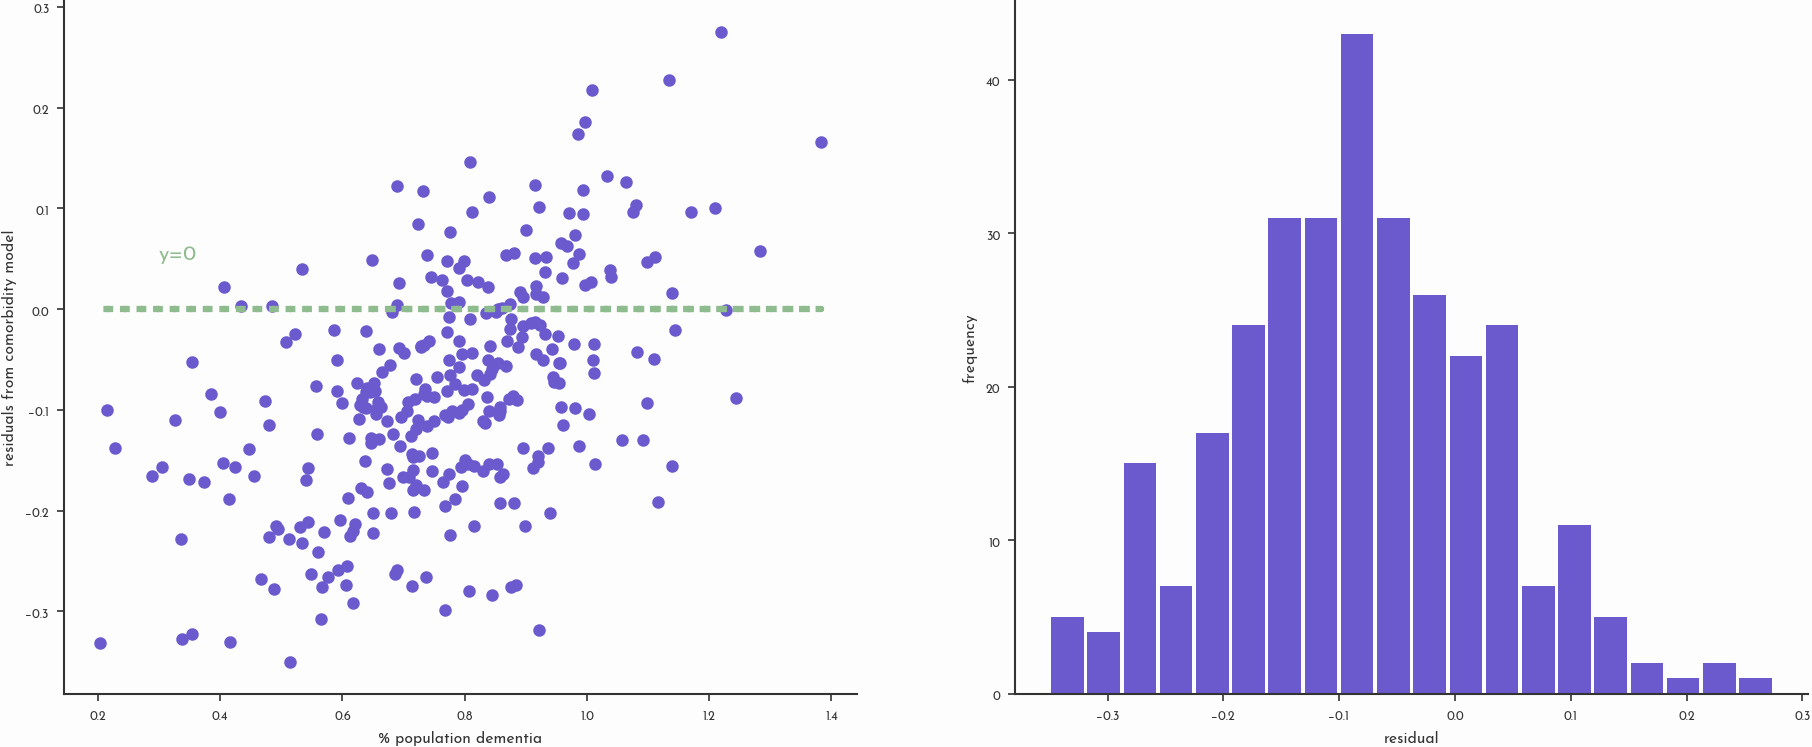

In [18]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

residuals = (y_test_all-y_pred_all)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y_test_all, residuals, color='slateblue')
plt.plot(y_test_all, np.zeros(len(y_test_all)), ':', color='darkseagreen')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, color='slateblue', rwidth=0.9, bins=20)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

And the same again, but leaving out the GP density covariate 

In [19]:
# Linear regression using sklearn 

x_IMD_train_noGP = df_dem_topIMD[covar_opt_noGP].values.reshape(-1,len(covar_opt_noGP))
y_IMD_train = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_noGP = df_dem_plus[covar_opt_noGP].values.reshape(-1,len(covar_opt_noGP))
y_test_all = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr_noGP = linear_model.LinearRegression()

# fit regression comorbidities
regr_noGP.fit(x_IMD_train_noGP, y_IMD_train)
y_pred_all_noGP = regr_noGP.predict(x_test_all_noGP)

print(f'intercept:{regr_noGP.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt_noGP):
    print(f'{covar}:{regr_noGP.coef_[0][i]} \n')

intercept:0.2537727407159407
-------- 
 coefficients of independent variables 
 
over_65_pc:0.016222644691389346 

female_pc:0.006458668934371755 

ALevel_plus_pc:-0.006027849410573279 

white_pc:-0.0045125377156956005 

HYP_afflicted_pc:0.010121593294666584 

DM_afflicted_pc:-0.024289787722671295 

STIA_afflicted_pc:0.23589687853973856 



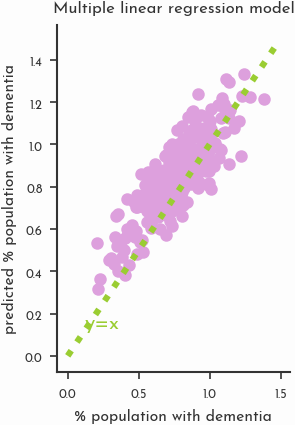

In [20]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y_test_all, y_pred_all_noGP, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(0.12, 0.13, r'y=x', fontsize=10, color='yellowgreen')
#plt.text(0.2, 0.12, r'potential underdiagnosis', fontsize=10)
plt.show()

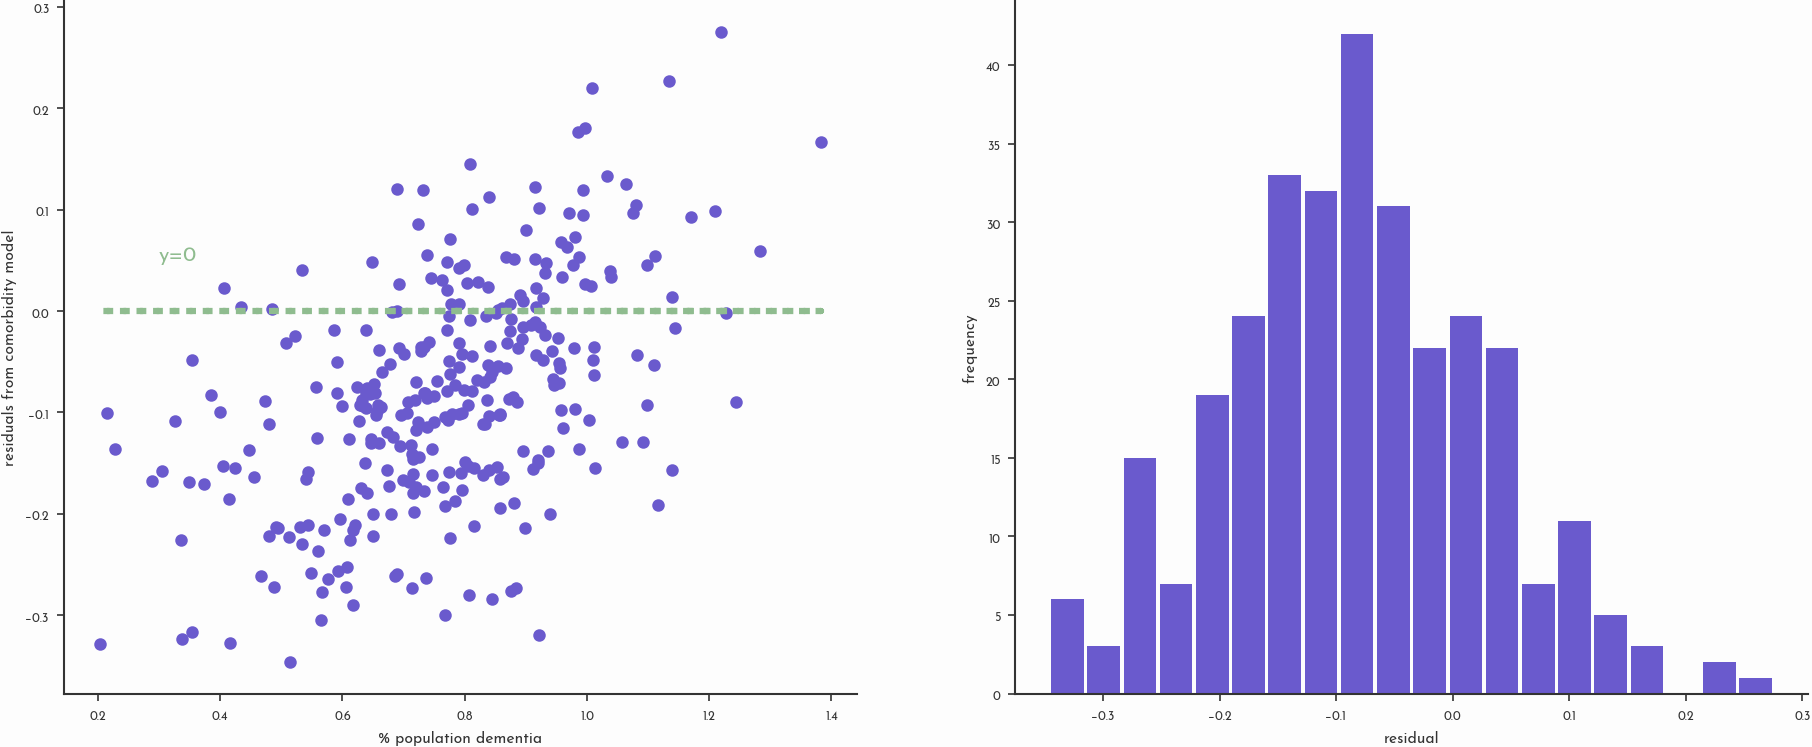

In [21]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

residuals_noGP = (y_test_all-y_pred_all_noGP)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y_test_all, residuals_noGP, color='slateblue')
plt.plot(y_test_all, np.zeros(len(y_test_all)), ':', color='darkseagreen')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(residuals_noGP, color='slateblue', rwidth=0.9, bins=20)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

### Save the results of the regression model to a .csv 

In [22]:
# add columns of results to the dataframe 
df_dem_plus['IMD_reg_model_residuals'] = residuals
df_dem_plus['IMD_reg_model_pred'] = y_pred_all

df_dem_plus['IMD_reg_model_noGP_residuals'] = residuals_noGP
df_dem_plus['IMD_reg_model_noGP_pred'] = y_pred_all_noGP

# save the dataframe 
df_dem_plus.to_csv(const.output_path+'/test_set_reg_model/IMD_reg_model_results.csv')

## Look at IMD rank of areas with large residuals

In [23]:
# Areas residuals 

# look at areas with gap between predicted diagnosis rate and observed diagnosis rate 
resid_gap_area = df_dem_plus[residuals<-0.3]['area_name']
print(resid_gap_area)
#[x for x in list(resid_gap_area)]

21     Barking and Dagenham
73                   Slough
75                 Redditch
132                  Ealing
197                Sandwell
284                  Newham
286                Torridge
Name: area_name, dtype: object


In [24]:
residuals[40]

array([-0.27949968])

In [25]:
df_dem_plus[df_dem_plus['area_name']=='South Hams']

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc,IMD_reg_model_residuals,IMD_reg_model_pred,IMD_reg_model_noGP_residuals,IMD_reg_model_noGP_pred
40,E07000044,South Hams,74072,597.62437,12201.179619,4036.440908,1928.689732,42560.0,46217.5554,42993.9842,...,62.395447,16.472054,5.449348,2.603804,133.272272,0.179923,-0.2795,1.086315,-0.279807,1.086622


In [26]:
worst_5_resid = np.argsort(np.array(residuals.reshape(309)))[-15:]
df_dem_plus.iloc[worst_5_resid, :][['area_name']+covar_opt]

,area_name,over_65_pc,female_pc,ALevel_plus_pc,white_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_LAD_pc
25,Worthing,27.574793,63.322383,50.175539,85.0,16.385577,6.617740,2.314350,0.110843
102,Colchester,21.530152,61.296004,50.439987,80.7,13.583193,4.800804,1.591681,0.102179
289,Lincoln,18.124966,61.697292,54.075785,82.7,11.432470,4.744160,1.545944,0.071612
10,Southend-on-Sea,23.600073,63.109901,44.333027,81.6,15.104013,5.784186,1.922887,0.137461
248,Guildford,20.409057,58.736111,61.339131,77.3,11.853822,4.275616,1.304893,0.287693
159,Rushcliffe,26.156822,61.437173,61.366935,86.1,13.192616,4.785857,1.947610,0.212437
119,Harrogate,28.871180,62.810418,57.045926,90.7,15.806634,5.160332,2.240924,0.165944
272,Gosport,25.530861,60.593137,43.336177,92.5,16.899720,7.549057,2.248049,0.073366
225,Southampton,16.705164,59.824464,51.816027,68.1,11.039538,5.131145,1.630277,0.201805
29,East Devon,36.652563,63.256897,52.088405,94.2,18.398179,6.787375,2.868139,0.141865


In [27]:
df_IMD[df_IMD['Local Authority District name (2019)'].isin(resid_gap_area)]

,Local Authority District code (2019),Local Authority District name (2019),IMD - Average rank,IMD - Rank of average rank,IMD - Average score,IMD - Rank of average score,IMD - Proportion of LSOAs in most deprived 10% nationally,IMD - Rank of proportion of LSOAs in most deprived 10% nationally,IMD 2019 - Extent,IMD 2019 - Rank of extent,IMD 2019 - Local concentration,IMD 2019 - Rank of local concentration
36,E06000039,Slough,19788.26,73,22.965,103,0.0000,195,0.1122,152,27534.97,172
85,E07000046,Torridge,20086.96,67,23.269,99,0.0000,195,0.1025,160,27564.45,171
237,E07000236,Redditch,17343.30,118,22.524,107,0.0909,86,0.2596,80,30212.17,104
274,E08000028,Sandwell,25276.49,8,34.884,12,0.1989,44,0.5349,10,31705.52,53
285,E09000002,Barking and Dagenham,25551.85,5,32.768,21,0.0364,139,0.4724,20,29391.87,125
292,E09000009,Ealing,18991.69,88,22.710,105,0.0204,163,0.1630,127,28827.66,143
308,E09000025,Newham,24138.70,12,29.577,43,0.0244,154,0.2884,67,28987.07,137


In [28]:
df_dem_plus_IMD = pd.merge(df_dem_plus, df_IMD[['IMD - Rank of average rank ', 'Local Authority District name (2019)']], left_on='area_name', right_on='Local Authority District name (2019)')

In [29]:
df_dem_plus_IMD.drop(columns='Local Authority District name (2019)', inplace=True)

In [30]:
df_dem_plus_IMD

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc,IMD_reg_model_residuals,IMD_reg_model_pred,IMD_reg_model_noGP_residuals,IMD_reg_model_noGP_pred,IMD - Rank of average rank
0,E07000091,New Forest,151481,1858.546949,28892.139020,9338.695410,4466.648271,72749.0,91513.3596,84729.6073,...,19.073111,6.164929,2.948652,186.084815,0.122844,-0.000987,1.227904,-0.001903,1.228820,241
1,E09000027,Richmond upon Thames,156795,1016.262785,16263.714161,5723.913130,2019.443594,112919.0,101226.6730,93918.3682,...,10.372597,3.650571,1.287952,437.450820,0.278995,0.049228,0.598919,0.048325,0.599823,297
2,E07000116,Tunbridge Wells,95022,876.255260,12908.434533,4606.674451,1889.024705,52395.0,59540.1412,56126.1458,...,13.584680,4.848008,1.987987,124.734713,0.131269,0.101652,0.820508,0.101994,0.820166,273
3,E07000121,Lancaster,123214,1228.376774,16806.421220,6784.714317,2647.583108,65724.0,72615.6480,69496.5141,...,13.640026,5.506448,2.148768,442.084950,0.358794,0.186271,0.810675,0.181119,0.815826,112
4,E07000042,Mid Devon,67987,547.793487,10854.465333,4281.878984,1530.207441,33190.0,42541.3752,40639.6312,...,15.965501,6.298085,2.250735,78.032656,0.114776,-0.154065,0.959798,-0.152533,0.958266,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,E07000098,Hertsmere,82921,670.292640,11021.724346,4685.682668,1328.437922,46875.0,56088.1445,51979.7732,...,13.291837,5.650779,1.602052,184.238057,0.222185,-0.010161,0.818512,-0.009256,0.817607,224
302,E08000024,Sunderland,228781,1815.593270,39805.733965,15607.611455,5391.466952,94211.0,141179.1277,133107.8801,...,17.399056,6.822075,2.356606,392.005902,0.171345,-0.156832,0.950426,-0.159221,0.952816,33
303,E06000050,Cheshire West and Chester,281913,2115.072286,42946.758704,16327.686339,5778.511168,157848.0,182966.3133,174617.3565,...,15.234047,5.791747,2.049750,262.879898,0.093249,-0.111419,0.861676,-0.109691,0.859948,183
304,E07000210,Mole Valley,72165,707.782207,10694.196102,3455.860767,1495.801962,42396.0,44954.5255,42642.7851,...,14.819090,4.788832,2.072753,136.391104,0.188999,0.073467,0.907317,0.073234,0.907549,294


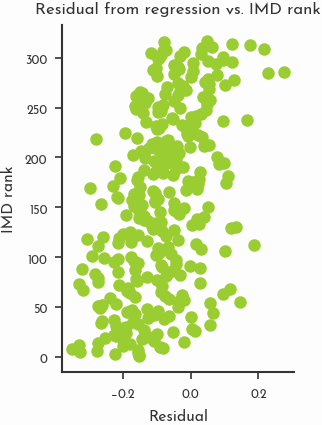

In [31]:
plt.scatter(df_dem_plus_IMD['IMD_reg_model_residuals'], df_dem_plus_IMD['IMD - Rank of average rank '], color='yellowgreen')
plt.xlabel('Residual')
plt.ylabel('IMD rank')
plt.title('Residual from regression vs. IMD rank')
plt.show()

### Ridge regression 

In [32]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_topIMD[covar_opt].values.reshape(-1,8)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[covar_opt].values.reshape(-1,8)

regr = linear_model.Ridge(alpha=1)

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

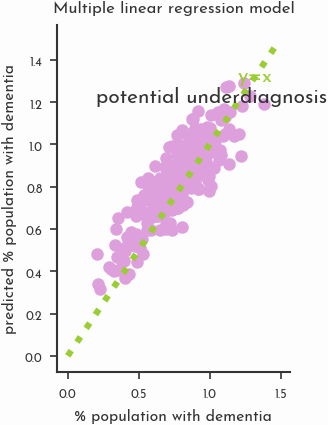

In [33]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10)
plt.show()

In [34]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.17969799653752516
-------- 
 coefficients of independent variables 
 
over_65_pc:0.021427982815773836 

female_pc:0.00416147913702485 

ALevel_plus_pc:-0.004622610498964374 

white_pc:-0.003078816589837118 

HYP_afflicted_pc:0.015229534963795387 

DM_afflicted_pc:-0.013480525238260745 

STIA_afflicted_pc:0.10763528553449174 

GP_LAD_pc:-0.015061373382992094 



In [35]:
np.dot(np.array(x_test_all_covar), regr.coef_[0]) + regr.intercept_[0]

array([1.17950491, 0.59704525, 0.78882817, 0.77987263, 0.95623521,
       0.70638565, 0.81577941, 0.85583334, 0.91404829, 0.78957366,
       0.84881816, 0.86072153, 0.89142098, 1.07129174, 0.91949944,
       0.8981493 , 1.03245531, 0.79275187, 0.85021357, 0.88643248,
       0.66349669, 0.59920115, 0.791702  , 0.88299493, 1.03774682,
       0.94821396, 0.80501583, 0.98665922, 0.91729841, 1.19279641,
       0.85636666, 1.15369938, 0.44165932, 0.97582009, 0.7927364 ,
       1.13682287, 0.8631315 , 0.73774349, 1.0476479 , 0.81058222,
       1.06871804, 0.40245133, 0.55275405, 0.65952727, 0.86103081,
       0.81112286, 0.7348423 , 0.94079557, 0.49476918, 0.89676905,
       0.93886334, 0.57696184, 0.71773353, 0.74214924, 0.78575935,
       0.90180435, 1.16577824, 0.69835418, 0.66870504, 0.99863769,
       0.73977173, 1.03556613, 0.31411575, 1.04915384, 0.84144579,
       0.65437975, 0.95682017, 0.79012918, 0.82203819, 0.6845485 ,
       0.68120066, 1.03449222, 0.88496237, 0.67923321, 1.15376

### Lasso regression 

In [36]:
# Alternative linear regression using sklearn 

x_all_covar = df_dem_topIMD[covar_opt].values.reshape(-1,8)
y = df_dem_topIMD['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all_covar = df_dem_plus[covar_opt].values.reshape(-1,8)

regr = linear_model.Lasso(alpha=0.001)

# fit regression comorbidities
regr.fit(x_all_covar, y)
y_pred_all = regr.predict(x_test_all_covar)

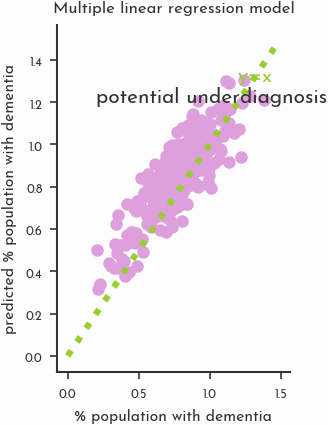

In [37]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 
true_val = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(true_val, y_pred_all, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(1.2, 1.3, r'y=x', fontsize=10, color='yellowgreen')
plt.text(0.2, 1.2, r'potential underdiagnosis', fontsize=10)
plt.show()

In [38]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt):
    print(f'{covar}:{regr.coef_[i]} \n')

intercept:0.09231771619329654
-------- 
 coefficients of independent variables 
 
over_65_pc:0.01883902789186213 

female_pc:0.005324509840840281 

ALevel_plus_pc:-0.004366294959799784 

white_pc:-0.0030462972119286043 

HYP_afflicted_pc:0.0074516115914967295 

DM_afflicted_pc:-0.0031765348826858575 

STIA_afflicted_pc:0.17126583697847442 

GP_LAD_pc:-0.0 



## Alternative using the GP density to select the training set 

In [39]:
# the 50 least deprived LADs according to the IMD
GP_vals = df_dem_plus['GP_LAD_pc'].values

df_highest_GP_50 = df_dem_plus.iloc[GP_vals.argsort()[-50:]]

# let's check this dataset 
df_highest_GP_50.head()

,area_code,area_name,pop,DEM_afflicted,HYP_afflicted,DM_afflicted,STIA_afflicted,ALevel_plus,Female_all,Male_all,...,female_pc,HYP_afflicted_pc,DM_afflicted_pc,STIA_afflicted_pc,GP_contribution_to_LAD,GP_LAD_pc,IMD_reg_model_residuals,IMD_reg_model_pred,IMD_reg_model_noGP_residuals,IMD_reg_model_noGP_pred
293,E07000207,Elmbridge,106578,793.043976,12241.934021,4095.114950,1613.911144,71488.0,71986.4337,67324.6442,...,67.543427,11.486361,3.842364,1.514300,216.889319,0.203503,0.032158,0.711940,0.032990,0.711107
101,E07000178,Oxford,124591,479.991181,9858.247645,4126.889686,1268.834016,93825.0,81271.8958,78442.7752,...,65.230952,7.912488,3.312350,1.018399,253.879066,0.203770,-0.084620,0.469873,-0.083218,0.468472
125,E07000194,Lichfield,87623,761.954449,14282.989024,5531.492554,1800.868206,45030.0,54224.1480,52626.6288,...,61.883464,16.300502,6.312832,2.055246,182.138652,0.207866,-0.031293,0.900876,-0.031762,0.901345
121,E09000003,Barnet,313694,2003.601221,35603.290480,16529.815112,4024.409402,190183.0,200300.8367,187905.7585,...,63.852301,11.349688,5.269407,1.282909,660.248227,0.210475,-0.082205,0.720917,-0.080537,0.719249
253,E07000066,Basildon,147650,836.308895,21230.763939,8435.195025,2707.627275,61857.0,96431.9056,91197.3989,...,65.311145,14.379115,5.712966,1.833815,312.348745,0.211547,-0.275825,0.842238,-0.277047,0.843460


In [40]:
# Potential covariates 
covar_opt_no_GP = ['over_65_pc', 
             'female_pc', 
             'ALevel_plus_pc', 
             'white_pc', 
             'HYP_afflicted_pc', 
             'DM_afflicted_pc', 
             'STIA_afflicted_pc']

In [41]:
# Linear regression using sklearn 

x_GP_train = df_highest_GP_50[covar_opt_no_GP].values.reshape(-1,len(covar_opt_no_GP))
y_GP_train = df_highest_GP_50['DEM_afflicted_pc'].values.reshape(-1,1)

x_test_all = df_dem_plus[covar_opt_no_GP].values.reshape(-1,len(covar_opt_no_GP))
y_test_all = df_dem_plus['DEM_afflicted_pc'].values.reshape(-1,1)

regr = linear_model.LinearRegression()

# fit regression comorbidities
regr.fit(x_GP_train, y_GP_train)
y_pred_all_GP = regr.predict(x_test_all)

In [42]:
print(f'intercept:{regr.intercept_[0]}')
print('-------- \n coefficients of independent variables \n ')
for i, covar in enumerate(covar_opt_no_GP):
    print(f'{covar}:{regr.coef_[0][i]} \n')

intercept:0.06976161697913308
-------- 
 coefficients of independent variables 
 
over_65_pc:0.021216327593908204 

female_pc:0.0027844439237098913 

ALevel_plus_pc:-0.0025997681155234286 

white_pc:-0.002434129158481422 

HYP_afflicted_pc:0.011464589960104823 

DM_afflicted_pc:-0.02593256161799395 

STIA_afflicted_pc:0.17845594423156588 



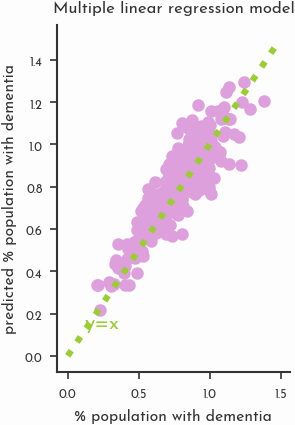

In [43]:
# comparison between true diagnosis value, and the value predicted by the multiple linear regression model 

plt.plot(np.arange(0, 1.5, 0.01), np.arange(0, 1.5, 0.01), ':', color='yellowgreen')
plt.scatter(y_test_all, y_pred_all_GP, color='plum')
plt.xlabel('% population with dementia')
plt.ylabel('predicted % population with dementia')
plt.title('Multiple linear regression model')
plt.text(0.12, 0.13, r'y=x', fontsize=10, color='yellowgreen')
#plt.text(0.2, 0.12, r'potential underdiagnosis', fontsize=10)
plt.show()

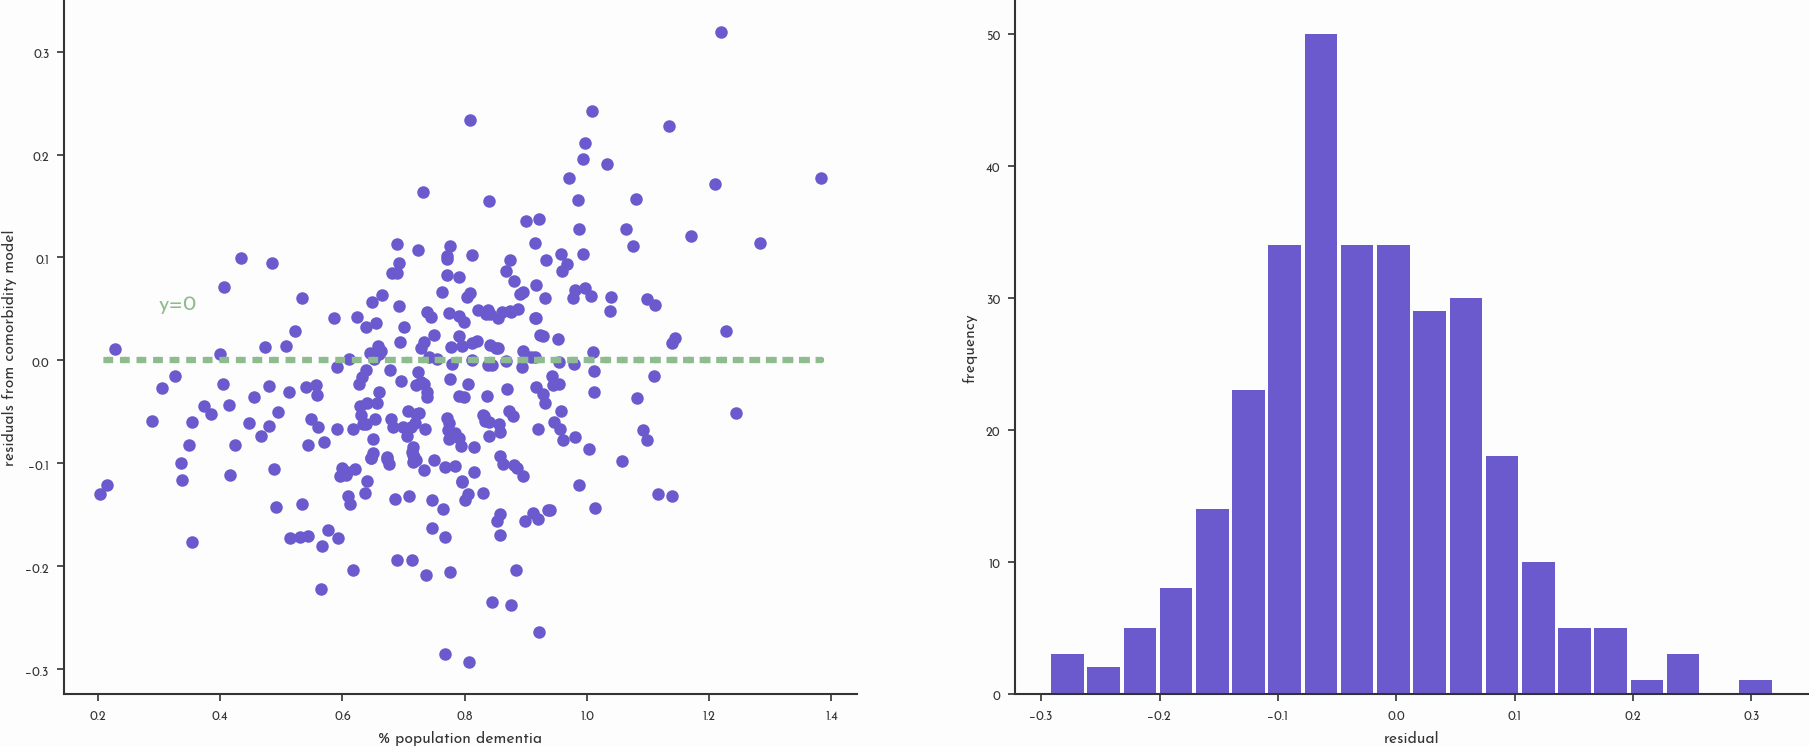

In [44]:
plt.subplots(nrows=1, ncols= 2, figsize = (15,6))

GP_residuals = (y_test_all-y_pred_all_GP)
 
# look at the residuals 
plt.subplot(1, 2, 1)
plt.scatter(y_test_all, GP_residuals, color='slateblue')
plt.plot(y_test_all, np.zeros(len(y_test_all)), ':', color='darkseagreen')
plt.text(0.3, 0.05, r'y=0', fontsize=10, color='darkseagreen')
plt.ylabel('residuals from comorbidity model')
plt.xlabel('% population dementia')

# histogram plot of the models residuals
plt.subplot(1, 2, 2)
plt.hist(GP_residuals, color='slateblue', rwidth=0.9, bins=20)
plt.xlabel('residual')
plt.ylabel('frequency')
plt.show()

In [45]:
# add columns of results to the dataframe 
df_dem_plus['GP_reg_model_residuals'] = GP_residuals
df_dem_plus['GP_reg_model_pred'] = y_pred_all_GP

# save the dataframe 
df_dem_plus.to_csv(const.output_path+'/test_set_reg_model/GP_reg_model_results.csv')